In [3]:
import pandas as pd
import pandas_profiling as pp
import sqlite3
import re
import numpy as np

%matplotlib qt
import matplotlib.pyplot as plt
import IPython

import plotly
import plotly.graph_objects as go
from plotly.offline import iplot
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
init_notebook_mode(connected=True)

Here we gather ideas what can be done with all the energy load data (industrial3 and residential3,4 seems to be most interesting, they might be studied in more detail):

1. Anomaly detection in load (e.g. weekly, daily, hourly), and with a distintion on particular loads
2. Typical daily/week consumption (e.g. with an alpha parameter)
3. Clustering days and loads
4. Analysis of PV data
5. Prediction of energy consumption
6. Kind of 'heat map' of the hourly consumption through years (plus violin, ridgeline plots)
7. Time characteristics of each device's load

In [4]:
# connecting to database
con = sqlite3.connect("household_data.sqlite")
cursor = con.execute('select * from household_data_60min_singleindex')

# get all the columns with indices
energy_columns = [(i, description[0]) for (i, description) in enumerate(cursor.description)]

In [5]:
# collect labels and indices for particular facilities
ind_labels = ['industrial1', 'industrial2', 'industrial3', 'public']
res_labels = ['residential{}'.format(i) for i in range(1,7)]
labels = ind_labels+res_labels
index_list = []
for label in labels:
    index_list.append([[item[0] for item in energy_columns if bool(re.search(label, item[1]))], 
                       [item[1] for item in energy_columns if bool(re.search(label, item[1]))]])

In [6]:
# define list of df's that contain hourly load data for all facilities and perform basic preprocessing
df_list = []
for i, label in enumerate(labels):
    # for each facility we query for respective columns with the join trick
    df = pd.read_sql_query('SELECT utc_timestamp, {} FROM household_data_60min_singleindex'.format(",".join(index_list[i][1])), con)
    df.iloc[:,0] = pd.to_datetime(df.iloc[:,0]) # change timestamp to datetime type
    df = df.set_index(df.iloc[:,0]).drop(columns='utc_timestamp') # new index from timestamp
    
    for col in df.columns:
        df[col+'_diff'] = df[col].diff() # in fact we need load differences that give hourly demand
        first_idx = df[col].first_valid_index()
        last_idx = df[col].last_valid_index()
        df = df.loc[first_idx:last_idx] 
    df = df.drop(columns=index_list[i][1]) # we can get rid of the incremental columns
    
    # let's mask anomalies ( > 3*std) with a median
    df.iloc[:,1:] = df.iloc[:,1:].mask((df.iloc[:,1:]-df.iloc[:,1:].mean()).abs() > 3*df.iloc[:,1:].std(), 
                                          other=df.iloc[:,1:].median(), axis=1)
    
    df_list.append(df)

In [120]:
# #visualizing all the curves for all facilities
# for df in df_list:
#     fig = go.Figure()
#     for col in df.columns:
#         fig.add_trace(go.Scatter(x = df.index,
#                                y = df[col],
#         #                                  visible='legendonly',
#                                name = col))

#         # fig["layout"].update({"xaxis": {"tickformat": "%H:%M"}})
#     fig.show(renderer="browser")

## Analysis of the industrial facility

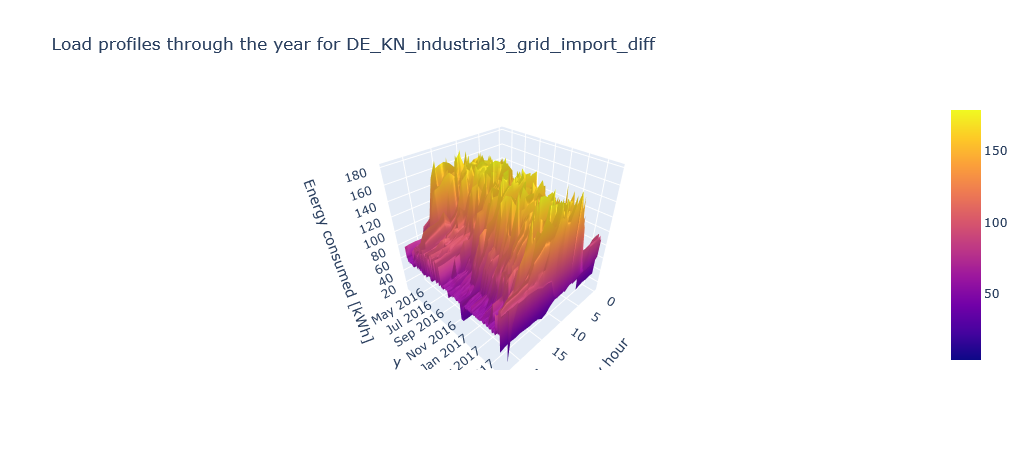

In [7]:
# let's copy df related to e.g. industrial3
df_ind = df_list[2].copy()

# to visualize load profiles in 3d, we pivot df on date and hour demand
df_ind['hour'] = df_ind.index.hour
df_ind['date'] = df_ind.index.date
for col in df_ind.columns[:-2]:
    df_pivot = df_ind.pivot(index='date', columns='hour', values=col)

    fig = go.Figure(data=[go.Surface(z=df_pivot.values,
                                    y = df_pivot.index,
                                    x = df_pivot.columns)])

    fig.update_layout(title='Load profiles through the year for {}'.format(col), autosize=True,
                      scene = dict(
                        xaxis_title='day hour',
                        zaxis_title="Energy consumed [kWh]")  
                     )

#     fig.show(renderer='browser')
    
    if col == 'DE_KN_industrial3_grid_import_diff':
#         fig.show('png', width=1500, height=800)
#         pio.write_image(fig, '{}.png'.format('3d_profile_load'))
#         fig.write_html('{}'.format('3d_profile_load'))
        iplot(fig)

## Analysis of the residiential facility

In [123]:
# let's copy df related to e.g. residiential3
df_res = df_list[6].copy()
df_res['hour'] = df_res.index.hour
df_res['date'] = df_res.index.date
df_res = df_res.set_index('date')

# plain heatmaps with a load profiles, without pivoting
for col in df_res[:-2]:
    fig = go.Figure(data=go.Heatmap(
            z=df_res[col],
            x=df_res.index,
            y=df_res.hour))

    fig.update_layout(title='load profiles through the year for {}'.format(col))

    fig.show(renderer='browser')

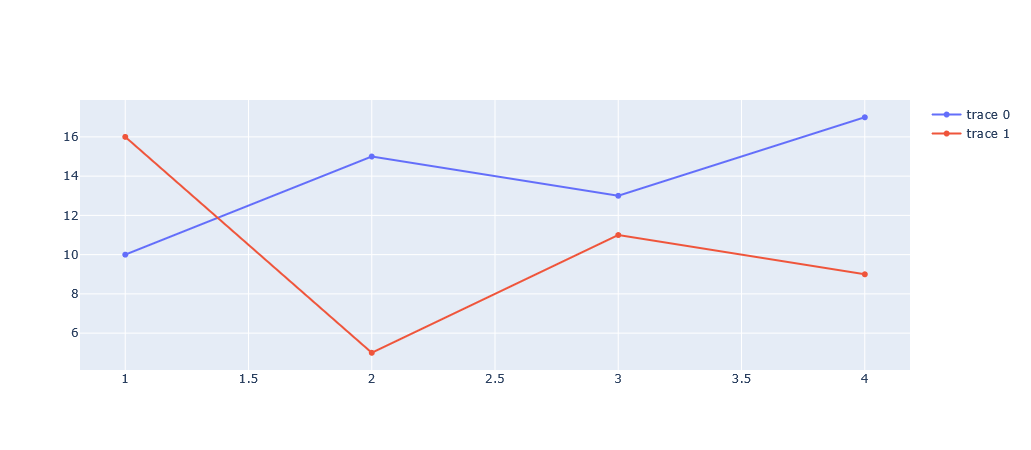

In [1]:
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *

init_notebook_mode(connected=True)         # initiate notebook for offline plot

trace0 = Scatter(
  x=[1, 2, 3, 4],
  y=[10, 15, 13, 17]
)
trace1 = Scatter(
  x=[1, 2, 3, 4],
  y=[16, 5, 11, 9]
)

iplot([trace0, trace1])